In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
np.random.seed(0)

In [2]:
def sigmoid(x):
    s = 1 / (1 + np.exp(1)**-x)
    return s

def sigmoid_inv(x):
    s = np.log(x / (1-x))
    return s


In [3]:
fold_number = 2

df_val= pd.read_csv('../input/jpeg-melanoma-512x512/train.csv', index_col="image_name")
df_val = df_val.query(f"tfrecord % 3 == {fold_number}")["target"]

In [4]:
b6_512c = pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0809/1638/CNN/oof_preds.csv", index_col="image_name")["target"]
b6_512m = pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0809/1638/MLP/oof_preds.csv", index_col="image_name")["target"]
b8_512c = pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0813/1700/CNN/oof_preds.csv", index_col="image_name")["target"]
b8_512m = pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0813/1700/MLP/oof_preds.csv", index_col="image_name")["target"]
b8_192c = pd.read_csv(f"../checkpoints/fold{fold_number}_192x192/0811/0812/CNN/oof_preds.csv", index_col="image_name")["target"]
b8_192m = pd.read_csv(f"../checkpoints/fold{fold_number}_192x192/0811/0812/MLP/oof_preds.csv", index_col="image_name")["target"]
b0_768c = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0811/2224/CNN/oof_preds.csv", index_col="image_name")["target"]
b0_768m = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0811/2224/MLP/oof_preds.csv", index_col="image_name")["target"]
b3_768c = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0813/0918/CNN/oof_preds.csv", index_col="image_name")["target"]
b3_768m = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0813/0918/MLP/oof_preds.csv", index_col="image_name")["target"]
b0_1024c = pd.read_csv(f"../checkpoints/fold{fold_number}_1024x1024/0812/2107/CNN/oof_preds.csv", index_col="image_name")["target"]
b0_1024m = pd.read_csv(f"../checkpoints/fold{fold_number}_1024x1024/0812/2107/MLP/oof_preds.csv", index_col="image_name")["target"]





b6_512c_l = sigmoid_inv(b6_512c)
b6_512m_l = sigmoid_inv(b6_512m)
b8_512c_l = sigmoid_inv(b8_512c)
b8_512m_l = sigmoid_inv(b8_512m)
b8_192c_l = sigmoid_inv(b8_192c)
b8_192m_l = sigmoid_inv(b8_192m)
b0_768c_l = sigmoid_inv(b0_768c)
b0_768m_l = sigmoid_inv(b0_768m)
b3_768c_l = sigmoid_inv(b3_768c)
b3_768m_l = sigmoid_inv(b3_768m)
b0_1024c_l = sigmoid_inv(b0_1024c)
b0_1024m_l = sigmoid_inv(b0_1024m)


preds = {
#     "b6_512c": b6_512c, 
    "b6_512m": b6_512m,
#     "b8_512c": b8_512c, 
    "b8_512m": b8_512m,
#     "b8_192c":b8_192c,
    "b8_192m":b8_192m,  
#     "b0_768c":b0_768c,
    "b0_768m":b0_768m,
#      "b3_768c":b3_768c,
    "b3_768m":b3_768m,   
#     "b0_1024c":b0_1024c,
    "b0_1024m":b0_1024m,
#     "b6_512c_l": b6_512c_l, 
#     "b6_512m_l": b6_512m_l,
#     "b8_512c_l": b8_512c_l, 
#     "b8_512m_l": b8_512m_l,
#     "b8_192c_l":b8_192c_l,
#     "b8_192m_l":b8_192m_l,  
#     "b0_768c_l":b0_768c_l,
#     "b0_768m_l":b0_768m_l,
#     "b3_768c_l":b3_768c_l,
#     "b3_768m_l":b3_768m_l,
#     "b0_1024c_l":b0_1024c_l,
#     "b0_1024m_l":b0_1024m_l,
}

print("現在のスコア")
for name, pred in preds.items():
    score = roc_auc_score(df_val, pred)
    print(f"{name:10}, {score:.4}")

現在のスコア
b6_512m   , 0.9304
b8_512m   , 0.9378
b8_192m   , 0.8964
b0_768m   , 0.9302
b3_768m   , 0.9373
b0_1024m  , 0.9287


In [5]:
delta = 10

best_weights = dict()
for name in preds.keys():
    best_weights[name] = 1

best_pred = pd.Series(0,index=df_val.index)
for name, pred in preds.items():
    best_pred += pred * best_weights[name]

wait_count = 0
roc_best = 0
while wait_count < 1000:
    for focus_name in preds.keys():
        tmp_pred = best_pred + preds[focus_name] * (delta / (wait_count + 1))
        tmp_score = roc_auc_score(df_val, tmp_pred)
        if roc_best <= tmp_score:
            best_weights[focus_name] += (delta / (wait_count + 1))
            roc_best = tmp_score
            best_pred = tmp_pred
            wait_count = 0
        else:
            wait_count +=1    
        
weights_sum = sum(best_weights.values())
for name in best_weights:
    best_weights[name] /= weights_sum
        
confirm_pred = pd.Series(0,index=df_val.index)
for name, pred in preds.items():
    confirm_pred += pred * best_weights[name]

print(roc_auc_score(df_val, confirm_pred))
print(roc_best)

0.9504948417491708
0.9504948417491708


In [6]:
best_weights

{'b6_512m': 0.13184862617152374,
 'b8_512m': 0.5787271201959864,
 'b8_192m': 0.011340716423591928,
 'b0_768m': 0.024616657863746786,
 'b3_768m': 0.16205661033410815,
 'b0_1024m': 0.09141026901104322}

In [7]:
b6_512c_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0809/1638/CNN/submission.csv", index_col="image_name")["target"]
b6_512m_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0809/1638/MLP/submission.csv", index_col="image_name")["target"]
b8_512c_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0813/1700/CNN/submission.csv", index_col="image_name")["target"]
b8_512m_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_512x512/0813/1700/MLP/submission.csv", index_col="image_name")["target"]
b8_192c_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_192x192/0811/0812/CNN/submission.csv", index_col="image_name")["target"]
b8_192m_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_192x192/0811/0812/MLP/submission.csv", index_col="image_name")["target"]
b0_768c_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0811/2224/CNN/submission.csv", index_col="image_name")["target"]
b0_768m_sub =  pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0811/2224/MLP/submission.csv", index_col="image_name")["target"]
b3_768c_sub = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0813/0918/CNN/submission.csv", index_col="image_name")["target"]
b3_768m_sub = pd.read_csv(f"../checkpoints/fold{fold_number}_768x768/0813/0918/MLP/submission.csv", index_col="image_name")["target"]
b0_1024c_sub = pd.read_csv(f"../checkpoints/fold{fold_number}_1024x1024/0812/2107/CNN/submission.csv", index_col="image_name")["target"]
b0_1024m_sub = pd.read_csv(f"../checkpoints/fold{fold_number}_1024x1024/0812/2107/MLP/submission.csv", index_col="image_name")["target"]




b6_512c_l_sub =  sigmoid_inv(b6_512c_sub)
b6_512m_l_sub =  sigmoid_inv(b6_512m_sub)
b8_512c_l_sub =  sigmoid_inv(b8_512c_sub)
b8_512m_l_sub =  sigmoid_inv(b8_512m_sub)
b8_192c_l_sub =  sigmoid_inv(b8_192c_sub)
b8_192m_l_sub =  sigmoid_inv(b8_192m_sub)
b0_768c_l_sub =  sigmoid_inv(b0_768c_sub)
b0_768m_l_sub =  sigmoid_inv(b0_768m_sub)
b3_768c_l_sub =  sigmoid_inv(b3_768c_sub)
b3_768m_l_sub =  sigmoid_inv(b3_768m_sub)
b0_1024c_l_sub =  sigmoid_inv(b0_1024c_sub)
b0_1024m_l_sub =  sigmoid_inv(b0_1024m_sub)

subs = {
#     "b6_512c_sub": b6_512c_sub, 
    "b6_512m_sub": b6_512m_sub,
#     "b8_512c_sub": b8_512c_sub, 
    "b8_512m_sub": b8_512m_sub,
#     "b8_192c_sub":b8_192c_sub,
    "b8_192m_sub":b8_192m_sub,  
#     "b0_768c_sub":b0_768c_sub,
    "b0_768m_sub":b0_768m_sub,
#     "b3_768c_sub":b3_768c_sub,
    "b3_768m_sub":b3_768m_sub,
#     "b0_1024c_sub":b0_1024c_sub,
    "b0_1024m_sub":b0_1024m_sub,
#     "b6_512c_l_sub": b6_512c_l_sub, 
#     "b6_512m_l_sub": b6_512m_l_sub,
#     "b8_512c_l_sub": b8_512c_l_sub, 
#     "b8_512m_l_sub": b8_512m_l_sub,
#     "b8_192c_l_sub":b8_192c_l_sub,
#     "b8_192m_l_sub":b8_192m_l_sub,  
#     "b0_768c_l_sub":b0_768c_l_sub,
#     "b0_768m_l_sub":b0_768m_l_sub,
#     "b3_768c_l_sub":b3_768c_l_sub,
#     "b3_768m_l_sub":b3_768m_l_sub,
#     "b0_1024c_l_sub":b0_1024c_l_sub,
#     "b0_1024m_l_sub":b0_1024m_l_sub,
}

In [8]:
submission = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv', index_col="image_name")
for name, sub in subs.items():
    print(name)
#     print((submission.index == sub.index).all())
    submission["target"] += sub.values * best_weights[name[:-4]]

b6_512m_sub
b8_512m_sub
b8_192m_sub
b0_768m_sub
b3_768m_sub
b0_1024m_sub


In [9]:
submission.to_csv(f"../output/submission_fold{fold_number}.csv")

In [10]:
submission

,target
image_name,
ISIC_0052060,0.000168
ISIC_0052349,0.000094
ISIC_0058510,0.000270
ISIC_0073313,0.000206
ISIC_0073502,0.000465
...,...
ISIC_9992485,0.001183
ISIC_9996992,0.005855
ISIC_9997917,0.019149


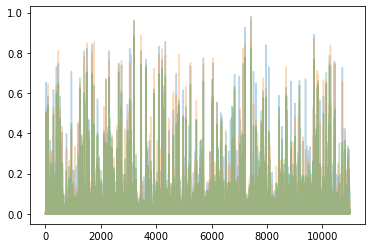

In [11]:
from scipy.stats import iqr

f0 = pd.read_csv("../output/submission_fold0.csv")
f1 = pd.read_csv("../output/submission_fold1.csv")
f2 = pd.read_csv("../output/submission_fold2.csv")

# f0["target"] = (f0["target"] - f0["target"].mean()) / f0["target"].std()
# f1["target"] = (f1["target"] - f1["target"].mean()) / f1["target"].std()
# f2["target"] = (f2["target"] - f2["target"].mean()) / f2["target"].std()

# f0["target"] = (f0["target"] - f0["target"].median()) / iqr(f0["target"])
# f1["target"] = (f1["target"] - f1["target"].median()) / iqr(f1["target"])
# f2["target"] = (f2["target"] - f2["target"].median()) / iqr(f2["target"])

import matplotlib.pyplot as plt

plt.plot(f0["target"], alpha=0.3)
plt.plot(f1["target"], alpha=0.3)
plt.plot(f2["target"], alpha=0.3)

new_preds = f0.copy()
new_preds["target"] = (f0["target"] + f1["target"] + f2["target"]) / 3

new_preds.to_csv("../output/submission.csv", index=None)

In [140]:
my_pred = new_preds.copy().set_index("image_name")
my_pred["target"] = (my_pred["target"] - my_pred["target"].mean()) / my_pred["target"].std()

my_pred["target"] = (my_pred["target"] - my_pred["target"].min()) / (my_pred["target"].max() - my_pred["target"].min())
my_pred["target"] **=2

sub_9581 = pd.read_csv("../output/submission9581.csv", index_col="image_name")

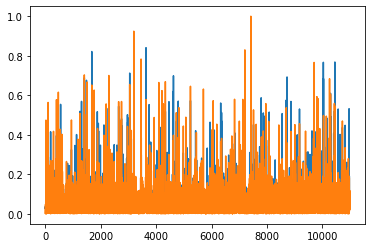

In [143]:
plt.plot(sub_9581["target"].values)
plt.plot(my_pred["target"].values)

In [148]:
((my_pred["target"] * 0.1) + (sub_9581["target"] * 0.9)).to_csv("../output/submission.csv")